# Continuous ensemble training
Now that the data, the network frameworks and the training loops are set up, we can investigate fruther.

In [19]:
# Reload module in case of changes
importlib.reload(utils)

<module 'lib.utils' from '/net/projects/scratch/winter/valid_until_31_July_2022/fheitzer/BAThesis-code/notebooks/../lib/utils.py'>

In [11]:
import tensorflow as tf
import numpy as np
import pandas as pd

import sys; sys.path.insert(0, '..')
import importlib

from lib import data, networks, training, utils

# Initialize the models

In [3]:
# load 10 class data
train_ds_pre, train_ds_post, test_ds, train_generator, test_generator = data.load_data(rotation=30)
dataset_shape = (tf.TensorSpec(shape=(28,28,1), dtype=tf.float64),
                tf.TensorSpec(shape=(10,), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32),
                tf.TensorSpec(shape=(10,), dtype=tf.float32))

num_classes = 10
# Small model
model1 = networks.NN([128, 128], num_classes)
# Broad Model
model2 = networks.NN([512], num_classes)
# Mixed Model
#model3a = networks.NN([256, 256], num_classes)

model3b = networks.CNN([(32, 3), (64, 5)])
# cnn
model4 = networks.CNN([(32, 3), (64, 5), (128, 7)], num_classes)
# cnn small
model5 = networks.CNN([(16, 3), (32, 3), (64, 5)], num_classes)
# ensemble
ensemble = networks.Ensemble([model1, model2, model3b, model4, model5])

model1.load_weights('../models/NN128128extra')
model2.load_weights('../models/NN512extra')
model3b.load_weights('../models/CNN3264extra')
model4.load_weights('../models/CNN3264128extra')
model5.load_weights('../models/CNN163264extra')

2022-04-19 16:51:12.295203: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-19 16:51:12.316157: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2496000000 Hz
2022-04-19 16:51:12.317534: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5569ca0eea40 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-04-19 16:51:12.317547: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


# Plot Cycle Accuracies

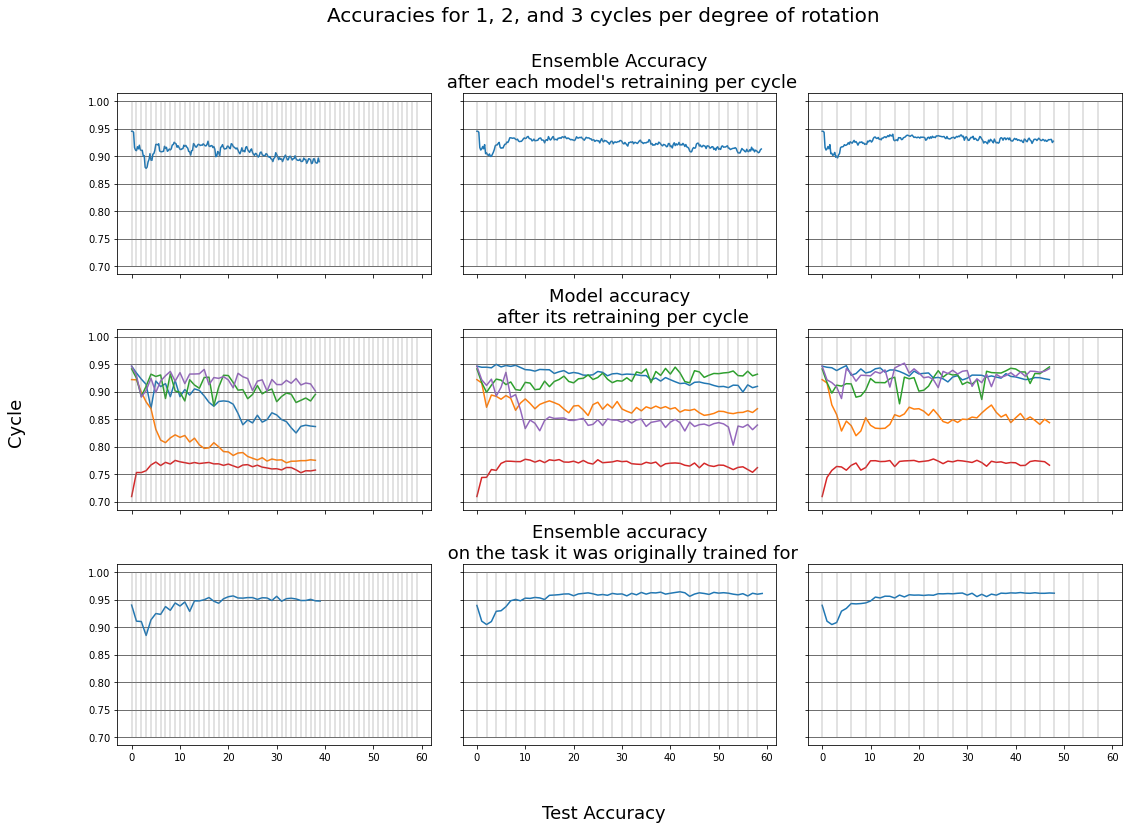

In [20]:
utils.plot_cycle_accuracies_grid(["Longcovid_r90_e1_b1_c90_d15000", "AYO_r180_e1_b1_c360_d15000", "Longcovid_r30_e1_b1_c90_d15000"])

# Plot Cycle Data Collection

## 180 degrees in 59/360 cycles

6787.0 collected datapoints labeled correct
238.0 collected datapoints were labeled wrong
271 datapoints were not classified.


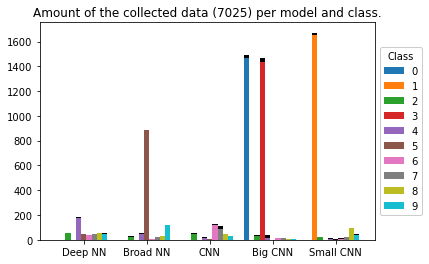

In [72]:
utils.plot_cycles_oneline(ensemble, "AYO_r180_e1_b1_c360_d15000", only_some=[-2,-1])

## 30 degrees in 48/90 cycles

5872.0 collected datapoints labeled correct
234.0 collected datapoints were labeled wrong
187 datapoints were not classified.


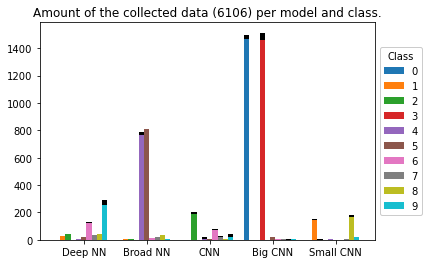

In [74]:
utils.plot_cycles_oneline(ensemble, "Longcovid_r30_e1_b1_c90_d15000", only_some=[-2,-1])

## 90 degrees in 39/90 cycles

7701.0 collected datapoints labeled correct
328.0 collected datapoints were labeled wrong
544 datapoints were not classified.


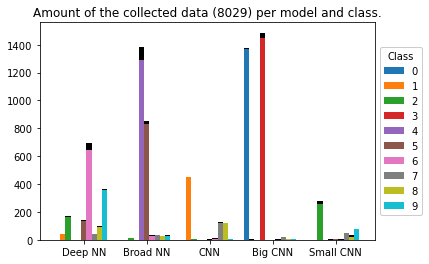

In [73]:
utils.plot_cycles_oneline(ensemble, "Longcovid_r90_e1_b1_c90_d15000", only_some=[-2,-1])